In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import joblib
from time import time

from scipy.optimize import curve_fit
import scipy.optimize

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

In [3]:
df = pd.read_excel('/content/estm.xlsx')
df

,Formula,temperature(K),seebeck_coefficient(μV/K),electrical_conductivity(S/m),thermal_conductivity(W/mK),power_factor(W/mK2),ZT,reference
0,BiSb(Se0.92Br0.08)3,300.0,-110.00,27766.0,0.6300,0.000336,0.159985,10.1002/adfm.201806558
1,BiSb(Se0.92Br0.08)3,400.0,-138.00,23883.0,0.5700,0.000455,0.319177,10.1002/adfm.201806558
2,BiSb(Se0.92Br0.08)3,500.0,-163.00,20850.0,0.5300,0.000554,0.522607,10.1002/adfm.201806558
3,BiSb(Se0.92Br0.08)3,600.0,-181.00,19000.0,0.5100,0.000622,0.732305,10.1002/adfm.201806558
4,BiSb(Se0.92Br0.08)3,700.0,-193.00,17925.0,0.5000,0.000668,0.940000,10.1002/adfm.201806558
...,...,...,...,...,...,...,...,...
5200,Ge9Sb2Te12,423.0,77.28,173636.0,2.8586,0.001037,0.153448,https://doi.org/10.1021/acsami.0c02155
5201,Ge9Sb2Te12,525.0,97.50,136364.0,2.7576,0.001296,0.246795,https://doi.org/10.1021/acsami.0c02155
5202,Ge9Sb2Te12,625.0,112.88,120000.0,2.8232,0.001529,0.338496,https://doi.org/10.1021/acsami.0c02155
5203,Ge9Sb2Te12,725.0,135.19,108182.0,2.5354,0.001977,0.565374,https://doi.org/10.1021/acsami.0c02155


In [4]:
badtemp_idx = []
# remove datapoints when ZT readings are so miniscule
for i in df.index:
    if df.loc[i]['ZT'] < 1e-2:
        df = df.drop(i)

# remove compounds with 2 or less readings
for i in df.index:
    currentcompound = df.loc[i]['Formula']
    if len(df[df['Formula'] == currentcompound]) < 3:
        df = df.drop(i)

df

,Formula,temperature(K),seebeck_coefficient(μV/K),electrical_conductivity(S/m),thermal_conductivity(W/mK),power_factor(W/mK2),ZT,reference
0,BiSb(Se0.92Br0.08)3,300.0,-110.00,27766.0,0.6300,0.000336,0.159985,10.1002/adfm.201806558
1,BiSb(Se0.92Br0.08)3,400.0,-138.00,23883.0,0.5700,0.000455,0.319177,10.1002/adfm.201806558
2,BiSb(Se0.92Br0.08)3,500.0,-163.00,20850.0,0.5300,0.000554,0.522607,10.1002/adfm.201806558
3,BiSb(Se0.92Br0.08)3,600.0,-181.00,19000.0,0.5100,0.000622,0.732305,10.1002/adfm.201806558
4,BiSb(Se0.92Br0.08)3,700.0,-193.00,17925.0,0.5000,0.000668,0.940000,10.1002/adfm.201806558
...,...,...,...,...,...,...,...,...
5200,Ge9Sb2Te12,423.0,77.28,173636.0,2.8586,0.001037,0.153448,https://doi.org/10.1021/acsami.0c02155
5201,Ge9Sb2Te12,525.0,97.50,136364.0,2.7576,0.001296,0.246795,https://doi.org/10.1021/acsami.0c02155
5202,Ge9Sb2Te12,625.0,112.88,120000.0,2.8232,0.001529,0.338496,https://doi.org/10.1021/acsami.0c02155
5203,Ge9Sb2Te12,725.0,135.19,108182.0,2.5354,0.001977,0.565374,https://doi.org/10.1021/acsami.0c02155


<Axes: ylabel='Frequency'>

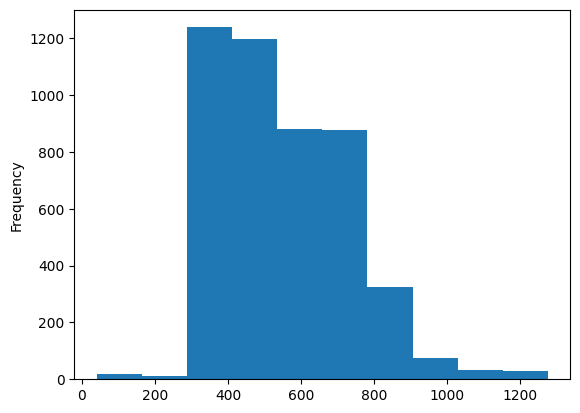

In [5]:
df['temperature(K)'].plot.hist()

<Axes: ylabel='Frequency'>

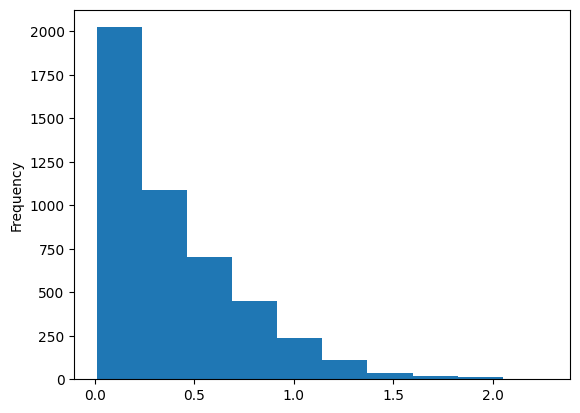

In [6]:
df['ZT'].plot.hist()

In [7]:
tempscaler = PowerTransformer(method='box-cox')
df['temp_new'] = tempscaler.fit_transform(df['temperature(K)'].to_numpy().reshape(-1, 1))
ztscaler = PowerTransformer(method='box-cox')
df['zt_new'] = ztscaler.fit_transform(df['ZT'].to_numpy().reshape(-1, 1))

df

,Formula,temperature(K),seebeck_coefficient(μV/K),electrical_conductivity(S/m),thermal_conductivity(W/mK),power_factor(W/mK2),ZT,reference,temp_new,zt_new
0,BiSb(Se0.92Br0.08)3,300.0,-110.00,27766.0,0.6300,0.000336,0.159985,10.1002/adfm.201806558,-1.547189,-0.500708
1,BiSb(Se0.92Br0.08)3,400.0,-138.00,23883.0,0.5700,0.000455,0.319177,10.1002/adfm.201806558,-0.794191,0.130892
2,BiSb(Se0.92Br0.08)3,500.0,-163.00,20850.0,0.5300,0.000554,0.522607,10.1002/adfm.201806558,-0.162882,0.656623
3,BiSb(Se0.92Br0.08)3,600.0,-181.00,19000.0,0.5100,0.000622,0.732305,10.1002/adfm.201806558,0.385801,1.057266
4,BiSb(Se0.92Br0.08)3,700.0,-193.00,17925.0,0.5000,0.000668,0.940000,10.1002/adfm.201806558,0.874113,1.377294
...,...,...,...,...,...,...,...,...,...,...
5200,Ge9Sb2Te12,423.0,77.28,173636.0,2.8586,0.001037,0.153448,https://doi.org/10.1021/acsami.0c02155,-0.640030,-0.535342
5201,Ge9Sb2Te12,525.0,97.50,136364.0,2.7576,0.001296,0.246795,https://doi.org/10.1021/acsami.0c02155,-0.019029,-0.117672
5202,Ge9Sb2Te12,625.0,112.88,120000.0,2.8232,0.001529,0.338496,https://doi.org/10.1021/acsami.0c02155,0.512888,0.190063
5203,Ge9Sb2Te12,725.0,135.19,108182.0,2.5354,0.001977,0.565374,https://doi.org/10.1021/acsami.0c02155,0.988519,0.746910


<Axes: ylabel='Frequency'>

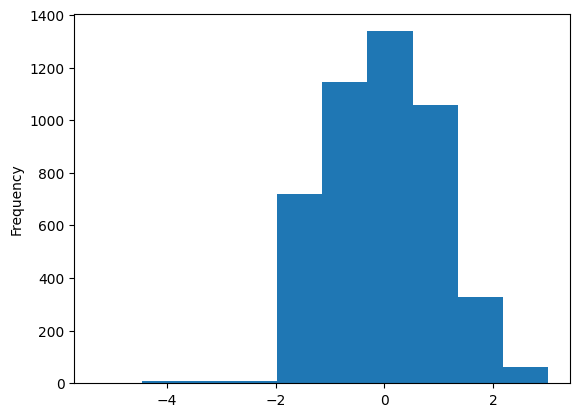

In [8]:
df['temp_new'].plot.hist()

<Axes: ylabel='Frequency'>

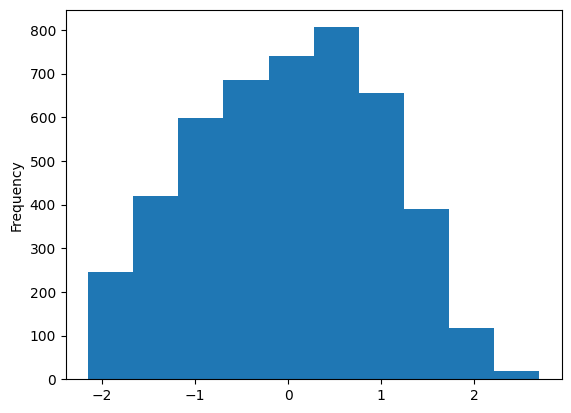

In [9]:
df['zt_new'].plot.hist()

In [10]:
unique_filtered = df.drop_duplicates(subset=['Formula'])['Formula']
unique_filtered

,Formula
0,BiSb(Se0.92Br0.08)3
6,BiSb(Se0.94Br0.06)3
12,BiSb(Se0.96Br0.04)3
18,BiSb(Se0.98Br0.02)3
24,Cu2.025Cd0.975SnSe4
...,...
5170,(Sn0.985In0.015Te)0.95(AgCl)0.05
5175,(Sn0.985In0.015Te)0.9(AgCl)0.1
5181,(Sn0.985In0.015Te)0.85(AgCl)0.15
5193,Cu2Sn0.95Fe0.05Se3


In [11]:
# look at good and bad examples

sussy_idx = []

for i in unique_filtered.index:
    if len(df.loc[df['Formula'] == unique_filtered[i]]) == 3:
        sussy_idx.append(i)

nonsussy_idx = []

for i in unique_filtered.index:
    if len(df.loc[df['Formula'] == unique_filtered[i]]) >= 5:
        nonsussy_idx.append(i)

In [12]:
class Magic():
    def __init__(self, decay_pt):
        self.coeff = None
        self.decay_pt = decay_pt

        # [a, m ,q,
        #  k, p]

        self.lowerbound = [-3, self.decay_pt-1, -5,
                           -1.5, 1e-2]

        self.upperbound = [3, self.decay_pt+1, 5,
                           1.5, 1.5]

        self.starting = [0, self.decay_pt, 0,
                         0.1, 1e-2]

    def log_decay(self, x, a, m, q, k, p):

        # sigmoid function forms the basis of the curve
        # exponential decay helps model flatness and slight drop off
        # parabola models sharper ZT-T peaks in a narrow T range

        # we set a, k, and b to smaller coeffs to deal with very small ZT (<0.01)
        # we limit b and c to prevent overflow numbers to NaN


        # coordinate coefficients [-5, 5]
        # a - upper asymptote of sigmoid
        # m - midpoint of sigmoid
        # n - start of decay
        # q - peak of parabola

        # gradient coefficients []
        # k - gradient of sigmoid
        # b - main factor for decay
        # c - sub factor for decay
        # p - main factor for parabola


        # we add a gating function within the exponential and power terms to prevent overflow
        func1 = a / (1 + np.exp(-k*(x-m)))
        func2 = -p*np.power(x-q,2)

        return np.clip(func1 + func2, -4, 4)

    def train(self, x, y):

        popt, pcov = curve_fit(self.log_decay, x, y, p0=self.starting,
                               method='trf',
                               bounds=(self.lowerbound,self.upperbound),
                               maxfev=1e5)

        self.coeff = popt

    def predict(self, x):

        return self.log_decay(x, *self.coeff)

<ipython-input-13-2539361500>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['abs_value'] = df_temp['seebeck_coefficient(μV/K)'].abs()
<ipython-input-12-517325627>:49: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.log_decay, x, y, p0=self.starting,
<ipython-input-13-2539361500>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['abs_value'] = df_temp['seebeck_coefficient(μV/K)'].abs()
<ipython-input-13-2539361500>:10: SettingWithCopyWarn

Compound GeSe0.8Te0.2 with index 5011 is problematic!
Compound Bi2Te2.55Se0.45 with index 1195 is problematic!


Text(0.5, 1.0, 'Good examples')

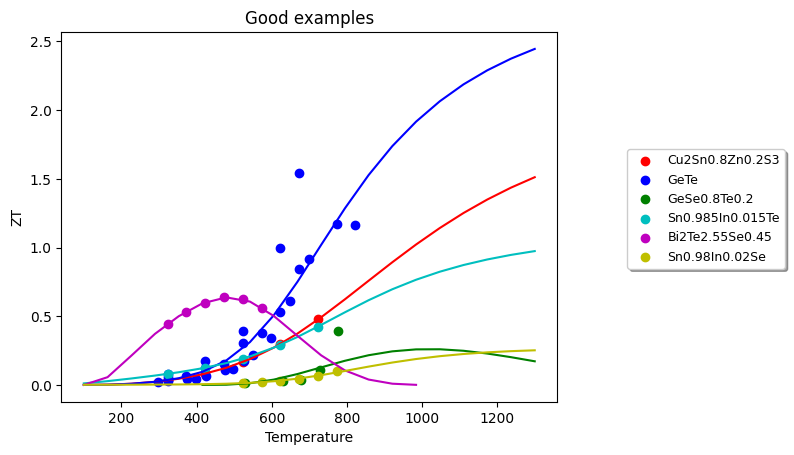

In [13]:
# a few preliminary testing for ZT-T approximation

random_num = np.random.choice(nonsussy_idx, 6)
random_names = unique_filtered[random_num]

for n, c in zip(random_num, ['r', 'b', 'g', 'c', 'm', 'y']):

    df_temp = df.loc[df['Formula'] == unique_filtered[n]]

    df_temp['abs_value'] = df_temp['seebeck_coefficient(μV/K)'].abs()
    idx = df_temp.groupby('Formula')['abs_value'].idxmax()
    df_tmax = df_temp.loc[idx].copy()
    df_tmax.drop('abs_value', axis=1, inplace=True)
    tmax = df_tmax['temp_new'].item()


    temp_X = df_temp['temp_new'].to_numpy()
    temp_y = df_temp['zt_new'].to_numpy()
    test_X = tempscaler.transform(np.linspace(100, 1300, 20).reshape(-1, 1))

    magic = Magic(decay_pt=tmax)
    magic.train(temp_X, temp_y)
    test_y = magic.predict(test_X)

    temp_y = ztscaler.inverse_transform(temp_y.reshape(-1, 1))
    test_y = ztscaler.inverse_transform(test_y.reshape(-1, 1))

    temp_X = tempscaler.inverse_transform(temp_X.reshape(-1, 1))
    test_X = tempscaler.inverse_transform(test_X.reshape(-1, 1))

    plt.plot(test_X, test_y, c=c)

    plt.scatter(temp_X, temp_y, label=f"{unique_filtered[n]}", c=c)


    if np.isnan(test_y).sum() > 0:
        print(f"Compound {unique_filtered[n]} with index {n} is problematic!")

plt.legend(loc='upper center', bbox_to_anchor=(1.3, 0.7), fontsize=9,
          ncol=1, fancybox=True, shadow=True)
plt.xlabel("Temperature")
plt.ylabel("ZT")
plt.title('Good examples')

<ipython-input-14-2325840988>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['abs_value'] = df_temp['seebeck_coefficient(μV/K)'].abs()
<ipython-input-12-517325627>:49: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.log_decay, x, y, p0=self.starting,
<ipython-input-14-2325840988>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['abs_value'] = df_temp['seebeck_coefficient(μV/K)'].abs()
<ipython-input-12-517325627>:49: OptimizeWarning: Cov

Compound Tl9.0Sb0.97Te6 with index 4118 is problematic!
Compound Ag(Bi0.8Pb0.2)0.7Sb0.3Se2 with index 3022 is problematic!
Compound Cu2Zn0.6Fe0.4SnSe4 with index 4180 is problematic!
Compound Ca5Ga2Sb6 with index 572 is problematic!


<ipython-input-12-517325627>:49: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.log_decay, x, y, p0=self.starting,
<ipython-input-14-2325840988>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['abs_value'] = df_temp['seebeck_coefficient(μV/K)'].abs()
<ipython-input-12-517325627>:49: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.log_decay, x, y, p0=self.starting,


Text(0.5, 1.0, 'Bad examples')

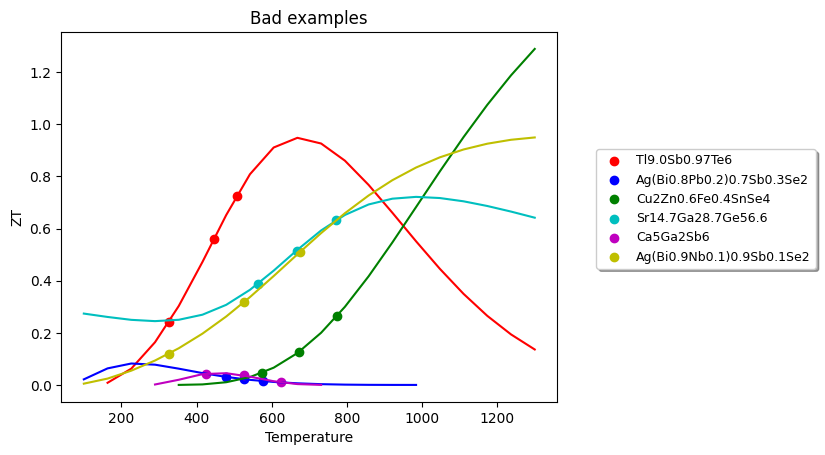

In [14]:
# a few preliminary testing for ZT-T approximation

random_num = np.random.choice(sussy_idx, 6)
random_names = unique_filtered[random_num]

for n, c in zip(random_num, ['r', 'b', 'g', 'c', 'm', 'y']):

    df_temp = df.loc[df['Formula'] == unique_filtered[n]]

    df_temp['abs_value'] = df_temp['seebeck_coefficient(μV/K)'].abs()
    idx = df_temp.groupby('Formula')['abs_value'].idxmax()
    df_tmax = df_temp.loc[idx].copy()
    df_tmax.drop('abs_value', axis=1, inplace=True)
    tmax = df_tmax['temp_new'].item()


    temp_X = df_temp['temp_new'].to_numpy()
    temp_y = df_temp['zt_new'].to_numpy()
    test_X = tempscaler.transform(np.linspace(100, 1300, 20).reshape(-1, 1))

    magic = Magic(decay_pt=tmax)
    magic.train(temp_X, temp_y)
    test_y = magic.predict(test_X)

    temp_y = ztscaler.inverse_transform(temp_y.reshape(-1, 1))
    test_y = ztscaler.inverse_transform(test_y.reshape(-1, 1))

    temp_X = tempscaler.inverse_transform(temp_X.reshape(-1, 1))
    test_X = tempscaler.inverse_transform(test_X.reshape(-1, 1))

    plt.plot(test_X, test_y, c=c)

    plt.scatter(temp_X, temp_y, label=f"{unique_filtered[n]}", c=c)


    if np.isnan(test_y).sum() > 0:
        print(f"Compound {unique_filtered[n]} with index {n} is problematic!")

plt.legend(loc='upper center', bbox_to_anchor=(1.3, 0.7), fontsize=9,
          ncol=1, fancybox=True, shadow=True)
plt.xlabel("Temperature")
plt.ylabel("ZT")
plt.title('Bad examples')